In [6]:
from collections import namedtuple
from distutils.version import LooseVersion
from graphviz import Digraph
import torch
from torch.autograd import Variable

Node = namedtuple('Node', ('name', 'inputs', 'attr', 'op'))


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph.
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert all(isinstance(p, Variable) for p in params.values())
        param_map = {id(v): k for k, v in params.items()}
    print(param_map.keys())
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '(' + (', ').join(['%d' % v for v in size]) + ')'

    output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)

    def add_nodes(var):
        if var not in seen:
            print(var)
            if torch.is_tensor(var):
                # note: this used to show .saved_tensors in pytorch0.2, but stopped
                # working as it was moved to ATen and Variable-Tensor merged
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                #print(u)
                print(id(u))
                #print(param_map[id(u)])
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            elif var in output_nodes:
                dot.node(str(id(var)), str(type(var).__name__), fillcolor='darkolivegreen1')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    # handle multiple outputs
    if isinstance(var, tuple):
        for v in var:
            add_nodes(v.grad_fn)
    else:
        add_nodes(var.grad_fn)

    resize_graph(dot)

    return dot


# For traces

def replace(name, scope):
    return '/'.join([scope[name], name])


def parse(graph):
    scope = {}
    for n in graph.nodes():
        inputs = [i.uniqueName() for i in n.inputs()]
        for i in range(1, len(inputs)):
            scope[inputs[i]] = n.scopeName()

        uname = next(n.outputs()).uniqueName()
        assert n.scopeName() != '', '{} has empty scope name'.format(n)
        scope[uname] = n.scopeName()
    scope['0'] = 'input'

    nodes = []
    for n in graph.nodes():
        attrs = {k: n[k] for k in n.attributeNames()}
        attrs = str(attrs).replace("'", ' ')
        inputs = [replace(i.uniqueName(), scope) for i in n.inputs()]
        uname = next(n.outputs()).uniqueName()
        nodes.append(Node(**{'name': replace(uname, scope),
                             'op': n.kind(),
                             'inputs': inputs,
                             'attr': attrs}))

    for n in graph.inputs():
        uname = n.uniqueName()
        if uname not in scope.keys():
            scope[uname] = 'unused'
        nodes.append(Node(**{'name': replace(uname, scope),
                             'op': 'Parameter',
                             'inputs': [],
                             'attr': str(n.type())}))

    return nodes


def make_dot_from_trace(trace):
    """ Produces graphs of torch.jit.trace outputs
    Example:
    >>> trace, = torch.jit.trace(model, args=(x,))
    >>> dot = make_dot_from_trace(trace)
    """
    # from tensorboardX
    if LooseVersion(torch.__version__) >= LooseVersion("0.4.1"):
        torch.onnx._optimize_trace(trace, torch._C._onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)
    elif LooseVersion(torch.__version__) >= LooseVersion("0.4"):
        torch.onnx._optimize_trace(trace, False)
    else:
        torch.onnx._optimize_trace(trace)
    graph = trace.graph()
    list_of_nodes = parse(graph)

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')

    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

    for node in list_of_nodes:
        dot.node(node.name, label=node.name.replace('/', '\n'))
        if node.inputs:
            for inp in node.inputs:
                dot.edge(inp, node.name)

    resize_graph(dot)

    return dot


def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.
    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

dict_keys([140017212762800, 140015287082008, 140015287081576, 140015287081648, 140017212062240, 140017212061016, 140017212060080, 140017212063392, 140017212061232, 140017212060800, 140017213688352])
140017212060800
140017212762800
140015287082008
140015287081576
140015287081648
140017212062240
140017212061016
140017212060080
140017212063392
140017212061232


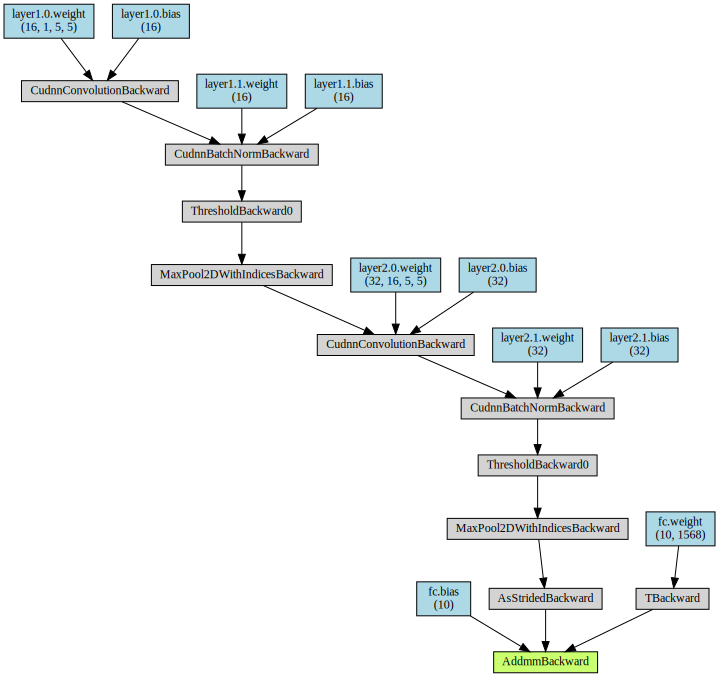

In [9]:
# from torchviz import make_dot
x = torch.randn(1, 1, 28, 28).to(device)
y = model(x)
#print(list(model.named_parameters()))
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        print(images.shape)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([10

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
Epoch [1/5], Step [300/600], Loss: 0.0026
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
t

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x7F46762D45C0>>
Traceback (most recent call last):
  File "/home/wuzhenyu_sjtu/anaconda3/envs/torch-1.0-py36/lib/python3.6/site-packages/PIL/Image.py", line 630, in __del__
    self.__exit__()
  File "/home/wuzhenyu_sjtu/anaconda3/envs/torch-1.0-py36/lib/python3.6/site-packages/PIL/Image.py", line 592, in __exit__
    if hasattr(self, "fp") and getattr(self, "_exclusive_fp", False):
KeyboardInterrupt


torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
Epoch [1/5], Step [400/600], Loss: 0.0194
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
t

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
Epoch [2/5], Step [100/600], Loss: 0.0033
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
t

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
Epoch [2/5], Step [400/600], Loss: 0.0047
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
t